In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import bokeh
import os
import geopandas
pd.options.display.max_colwidth=200
%matplotlib inline

## Get the data

In [2]:
# data directory
data_dir = "../data"
raw_data = os.path.join(data_dir, "raw")

# read in the data
df = pd.read_csv(os.path.join(raw_data, "summary_listings.csv"))
nbhoods = geopandas.read_file(os.path.join(raw_data, "neighbourhoods.geojson"))
subway = geopandas.read_file(os.path.join(raw_data, "subway.geojson"))

# use only roomtype: entire home/apt
nyc_df = df[df.room_type == 'Entire home/apt']
#manhattan_nbhoods = nbhoods[nbhoods.neighbourhood_group == 'Manhattan']


# construct a geodataframe
nyc_df = geopandas.GeoDataFrame(nyc_df, geometry=geopandas.points_from_xy(nyc_df.longitude, 
                                                                            nyc_df.latitude))

# filter 
cols = ['price', 'neighbourhood', 'neighbourhood_group', 'geometry']
nyc_df = nyc_df[cols]

Check the shape of each of the data frames. 
* **manhattan_df**: Contains the airbnb data for just Manhattan neighbourhoods with room type entire home/apt
* **manhattan_nbhoods**: Contains just the 32 Manhattan neighbourhoods.
* **subway**: Contains subway data for all 5 boroughs. So, we need to filter this to include on Manhattan subway stations. To do this we need to do some work, since the subway data is not broken down by neighbhourhoods.

In [3]:
display(nyc_df.shape)
display(nbhoods.shape)
display(subway.shape)

(25296, 4)

(233, 3)

(473, 6)

To obtain the neighbourhoods of subway stations, we need to perform what is known as a **spatial join**.

In [4]:
subway.head()

,name,url,line,objectid,notes,geometry
0,Astor Pl,http://web.mta.info/nyct/service/,4-6-6 Express,1,"4 nights, 6-all times, 6 Express-weekdays AM southbound, PM northbound",POINT (-73.99106999861966 40.73005400028978)
1,Canal St,http://web.mta.info/nyct/service/,4-6-6 Express,2,"4 nights, 6-all times, 6 Express-weekdays AM southbound, PM northbound",POINT (-74.00019299927328 40.71880300107709)
2,50th St,http://web.mta.info/nyct/service/,1-2,3,"1-all times, 2-nights",POINT (-73.98384899986625 40.76172799961419)
3,Bergen St,http://web.mta.info/nyct/service/,2-3-4,4,"4-nights, 3-all other times, 2-all times",POINT (-73.97499915116808 40.68086213682956)
4,Pennsylvania Ave,http://web.mta.info/nyct/service/,3-4,5,"4-nights, 3-all other times",POINT (-73.89488591154061 40.66471445143568)


In [5]:
nbhoods.head()

,neighbourhood,neighbourhood_group,geometry
0,Bayswater,Queens,"(POLYGON ((-73.76670799999999 40.614911, -73.768253 40.614878, -73.773977 40.616004, -73.77363099999999 40.616327, -73.76873500000001 40.620901, -73.767459 40.620511, -73.76697799999999 40.616919,..."
1,Allerton,Bronx,"(POLYGON ((-73.848597 40.87167, -73.845823 40.870239, -73.85455899999999 40.859954, -73.854665 40.859586, -73.85638899999999 40.857594, -73.868882 40.857223, -73.868318 40.857862, -73.869553999999..."
2,City Island,Bronx,"(POLYGON ((-73.782822 40.843919, -73.782572 40.843295, -73.782607 40.843286, -73.782785 40.843755, -73.783092 40.843685, -73.78287400000001 40.843124, -73.782901 40.843118, -73.78313300000001 40.8..."
3,Ditmars Steinway,Queens,"(POLYGON ((-73.90160299999999 40.76777, -73.90390600000001 40.76814, -73.904667 40.768545, -73.90560499999999 40.768717, -73.916607 40.770407, -73.91726199999999 40.770785, -73.92232300000001 40.7..."
4,Ozone Park,Queens,"(POLYGON ((-73.83754399999999 40.691364, -73.83108300000001 40.678151, -73.83087500000001 40.678109, -73.83094 40.67812, -73.83208 40.675261, -73.83305300000001 40.675412, -73.83375599999999 40.67..."


In [10]:
nbhoods.shape

(233, 3)

Here, our goal is to find out whether each of the subway stations - represented by `Point()` objects, is contained within the neighbourhood - represented by `Polygon()` objects. One way to do this, is to extract the neighbourhood polygon for let's say "Battery Park City", and then, use the `within()` GeoSeries method to check whether the subway point is within the neighbourhood. This works fine, but what if we want to do this for each and every neighbourhood? 

This is where a **spatial join** comes handy. Since the neighbourhood column is part of `manhattan_nbhoods` dataframe, we need to combine/join both `manhattan_nbhoods and subway` datasets. **Joining on location rather than on a shared column is called a spatial join**. 

In [6]:
nyc_subway = geopandas.sjoin(subway, 
                         nbhoods[['neighbourhood', 'geometry']],
                        op='within')

In [7]:
nyc_subway.head()

,name,url,line,objectid,notes,geometry,index_right,neighbourhood
0,Astor Pl,http://web.mta.info/nyct/service/,4-6-6 Express,1,"4 nights, 6-all times, 6 Express-weekdays AM southbound, PM northbound",POINT (-73.99106999861966 40.73005400028978),87,East Village
145,1st Ave,http://web.mta.info/nyct/service/,L,146,L-all times,POINT (-73.98168087489128 40.73097497580066),87,East Village
370,Lower East Side - 2nd Ave,http://web.mta.info/nyct/service/,F,371,F-all times,POINT (-73.98993800003434 40.72340166574911),87,East Village
382,3rd Ave,http://web.mta.info/nyct/service/,L,383,L-all times,POINT (-73.98575000112093 40.73269099971662),87,East Village
383,Union Sq - 14th St,http://web.mta.info/nyct/service/,L,384,L-all times,POINT (-73.99066976901818 40.73476331217923),87,East Village


In [8]:
nyc_subway.shape

(459, 8)

So, this seems right, we have **459** subway stations just in NYC. Astounding!

### Check the Coordinate Reference System of the geodataframe
Before I move further to plotting this data on the map and doing distance calculations, it is vital to ensure that all locations are expressed in a common CRS. Moreover, NYC uses a specific EPSG value of 2829 or 32117. 

Reference: https://spatialreference.org/ref/?search=New+york&srtext=Search

In [12]:
print(nyc_df.crs)
print(nbhoods.crs)
print(subway.crs)

None
{'init': 'epsg:4326'}
{'init': 'epsg:4326'}


The CRS attribute is missing for our airbnb dataset. We can set this easily by doing:

In [13]:
nyc_df.crs = {'init': 'epsg:4326'}

In [14]:
print(nyc_df.crs)
print(nbhoods.crs)
print(subway.crs)

{'init': 'epsg:4326'}
{'init': 'epsg:4326'}
{'init': 'epsg:4326'}


In [15]:
# To avoid SettingWithCopyWarning, store the result in a new dfs.
nyc_df_crs = nyc_df.to_crs(epsg=2829)
nbhoods_crs = nbhoods.to_crs(epsg=2829)
subway_crs = subway.to_crs(epsg=2829)

In [16]:
print(nyc_df_crs.crs)
print(nbhoods_crs.crs)
print(subway_crs.crs)

{'init': 'epsg:2829', 'no_defs': True}
{'init': 'epsg:2829', 'no_defs': True}
{'init': 'epsg:2829', 'no_defs': True}


## Plot all the data

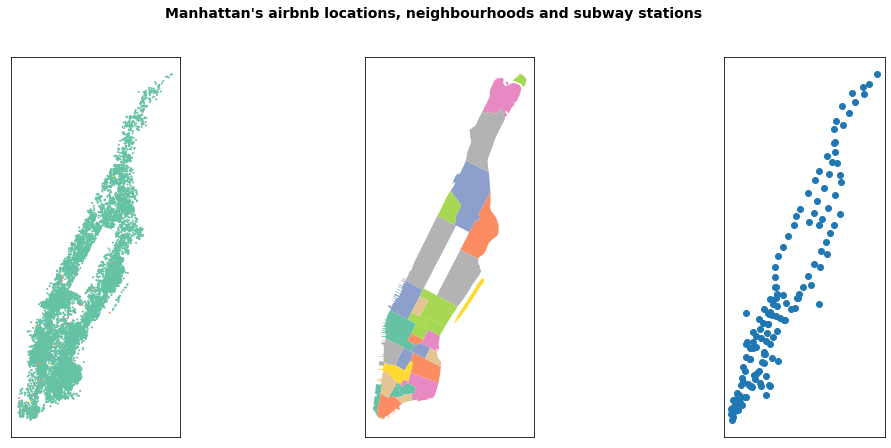

In [73]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
fig.set_size_inches(18, 7)

# airbnb locations
ax1 = manhattan_df_crs.plot(ax=ax1, 
                            column='price', 
                            cmap='Set2', 
                            markersize=1)
ax1.axes.get_xaxis().set_visible(False)
ax1.axes.get_yaxis().set_visible(False)

# nbhoods
ax2 = manhattan_nbhoods_crs.plot(ax=ax2, 
                                 column='neighbourhood', 
                                 cmap='Set2')
ax2.axes.get_xaxis().set_visible(False)
ax2.axes.get_yaxis().set_visible(False)

# subway stations
ax3 = manhattan_subway_crs.plot(ax=ax3)
ax3.axes.get_xaxis().set_visible(False)
ax3.axes.get_yaxis().set_visible(False)


plt.suptitle("Manhattan's airbnb locations, neighbourhoods and subway stations", 
             fontsize=14, fontweight='bold')
plt.show()

### EDA: Calculate the median neighbourhood price

In [17]:
nyc_df_crs_grouped = nyc_df_crs.groupby('neighbourhood')[['price']].median()

median_price_df = pd.merge(nyc_df_crs, nyc_df_crs_grouped, 
                           left_on='neighbourhood', right_index=True)
median_price_df.rename({'price_x': 'price', 
                        'price_y': 'median_neighbourhood_price'}, 
                       axis=1, inplace=True)

nyc_df_crs_grouped.sort_values(by='price', ascending=False)

,price
neighbourhood,
Fort Wadsworth,800.0
Woodrow,700.0
Tribeca,318.0
Willowbrook,299.0
South Beach,275.0
...,...
Tremont,68.0
Soundview,60.0
New Dorp,57.0


### EDA: Plot the median neighbourhood price
Now let's overlay this on the map and color code it to visually see how the price differs by location.

In [18]:
median_price_df.head()

,price,neighbourhood,neighbourhood_group,geometry,median_neighbourhood_price
0,225,Midtown,Manhattan,POINT (469524.6984892281 86930.35771388965),220.0
229,250,Midtown,Manhattan,POINT (470677.7776314804 87551.5385397778),220.0
241,110,Midtown,Manhattan,POINT (470761.827736628 87397.31060812931),220.0
372,139,Midtown,Manhattan,POINT (469131.4848167276 85963.88072752411),220.0
380,145,Midtown,Manhattan,POINT (470934.6724387425 87213.49589937051),220.0


In [31]:
nbhoods_crs.head()

,neighbourhood,neighbourhood_group,geometry
0,Bayswater,Queens,"(POLYGON ((488351.0841146582 72091.23434415823, 488220.4427919586 72083.38265534681, 487732.0062449042 72192.94529184919, 487760.1428067125 72229.75321616138, 488158.2400119834 72750.99276728938, ..."
1,Allerton,Bronx,"(POLYGON ((480531.5653169187 100388.399222481, 480770.4052078897 100236.7819061674, 480069.5063578718 99071.49487716163, 480061.8426183849 99030.345140901, 479923.3648789927 98804.57727892668, 478..."
2,City Island,Bronx,"(POLYGON ((486175.5009672301 97481.69142680799, 486198.8040113274 97413.06250016346, 486195.883965528 97411.96848221295, 486179.2043723824 97463.57687489403, 486153.5597616356 97454.97409970534, 4..."
3,Ditmars Steinway,Queens,"(POLYGON ((476416.1213784565 88710.79794049644, 476220.4042462896 88745.94512906118, 476154.772902329 88788.96124791073, 476074.9873389237 88805.64435077185, 475140.3027628487 88965.02317688744, 4..."
4,Ozone Park,Queens,"(POLYGON ((482090.7222404248 80392.49858250844, 482682.896199414 78942.15743485499, 482700.6293241839 78938.04400384783, 482695.0951156875 78939.09344359365, 482608.650493801 78618.55249795975, 48..."


Color by median_neighbourhood_price

In [88]:
def plot_borough(borough_name, ax):
    
    if borough_name == "all":
        ax = nbhoods_crs.plot(ax=ax, 
                              figsize=(8,8), 
                              color='white', 
                              edgecolor='green')
    
        ax = median_price_df.plot(ax=ax, 
                                  markersize=1,
                                  legend=True,
                                  column='median_neighbourhood_price', 
                                  cmap='BuPu')
    else:
        
        ax = nbhoods_crs[nbhoods_crs.neighbourhood_group \
                         == borough_name].plot(ax=ax, figsize=(8,8), 
                                               color='white', 
                                               edgecolor='green'
                                              )
        ax = median_price_df[median_price_df.neighbourhood_group \
                             == borough_name].plot(ax=ax, 
                                                   markersize=1,
                                                   legend=True,
                                                   column='median_neighbourhood_price', 
                                                   cmap='BuPu'
                                                  )

    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)
    return ax

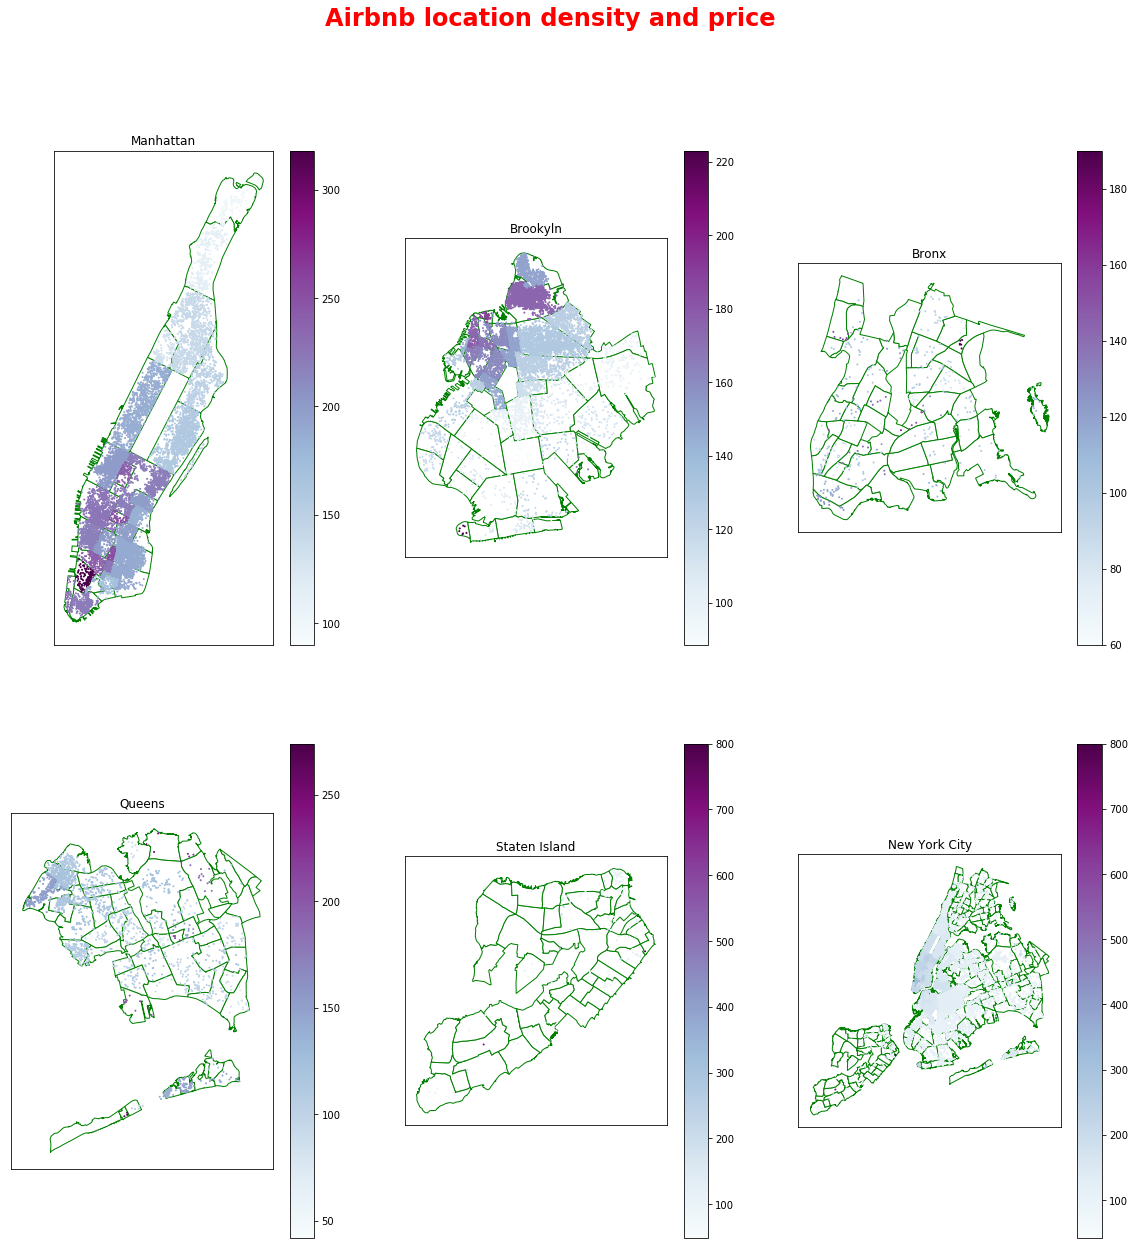

In [99]:
fig, axes = plt.subplots(2, 3)
fig.set_size_inches(20, 20)
axes[0,0] = plot_borough("Manhattan", axes[0,0])
axes[0,0].set_title("Manhattan")
axes[0,1] = plot_borough("Brooklyn", axes[0,1])
axes[0,1].set_title("Brookyln")
axes[0,2] = plot_borough("Bronx", axes[0,2])
axes[0,2].set_title("Bronx")
axes[1,0] = plot_borough("Queens", axes[1,0])
axes[1,0].set_title("Queens")
axes[1,1] = plot_borough("Staten Island", axes[1,1])
axes[1,1].set_title("Staten Island")
axes[1,2] = plot_borough("all", axes[1,2])
axes[1,2].set_title("New York City")

plt.suptitle("Airbnb location density and price", 
             fontsize=24, fontweight='bold', color='red')
plt.show()

In [61]:
cloropeth_price_df = pd.merge(nbhoods_crs, nyc_df_crs_grouped, 
                              left_on='neighbourhood', right_index=True)

In [62]:
cloropeth_price_df.head()

,neighbourhood,neighbourhood_group,geometry,price
0,Bayswater,Queens,"(POLYGON ((488351.0841146582 72091.23434415823, 488220.4427919586 72083.38265534681, 487732.0062449042 72192.94529184919, 487760.1428067125 72229.75321616138, 488158.2400119834 72750.99276728938, ...",112.5
22,Bayswater,Queens,"(POLYGON ((488494.9165870835 71946.53524287442, 488499.3946967966 71936.33953856048, 488489.0994079471 71892.76284004004, 488494.3769011298 71825.89387942158, 488506.6787823386 71809.50077693186, ...",112.5
1,Allerton,Bronx,"(POLYGON ((480531.5653169187 100388.399222481, 480770.4052078897 100236.7819061674, 480069.5063578718 99071.49487716163, 480061.8426183849 99030.345140901, 479923.3648789927 98804.57727892668, 478...",100.0
2,City Island,Bronx,"(POLYGON ((486175.5009672301 97481.69142680799, 486198.8040113274 97413.06250016346, 486195.883965528 97411.96848221295, 486179.2043723824 97463.57687489403, 486153.5597616356 97454.97409970534, 4...",110.0
44,City Island,Bronx,"(POLYGON ((485971.8018503094 99231.32903837867, 485962.508488977 99170.88498706152, 485938.0451526552 99146.64431320957, 485922.2536500815 99131.01928571734, 485916.4573934741 99148.62228885386, 4...",110.0


In [94]:
def plot_coloropeth_borough(borough_name, ax, legend_pos):
    
    if borough_name == "all":
        ax = cloropeth_price_df.plot(ax=ax, 
                                     figsize=(15,15), 
                                     column='price', 
                                     cmap='OrRd', 
                                     scheme='quantiles',
                                     edgecolor='orange', 
                                     legend=True, 
                                     legend_kwds = legend_pos
                                    )
    else:
        ax = cloropeth_price_df[cloropeth_price_df.neighbourhood_group \
                                == borough_name].plot(ax=ax, 
                                                      figsize=(10,10), 
                                                      column='price', 
                                                      cmap='OrRd', 
                                                      scheme='quantiles',
                                                      edgecolor='orange', 
                                                      legend=True, 
                                                      legend_kwds = legend_pos
                                                     )

    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)
    return ax

In [90]:
legend_pos = {
    "all": {'loc':'upper left'},
    "Manhattan": {'loc':'upper left'},
    "Brooklyn": {'loc':'lower right'},
    "Bronx": {'loc':'upper right'},
    "Queens": {'loc':'lower left'},
    "Staten Island": {'loc':'lower right'}
}

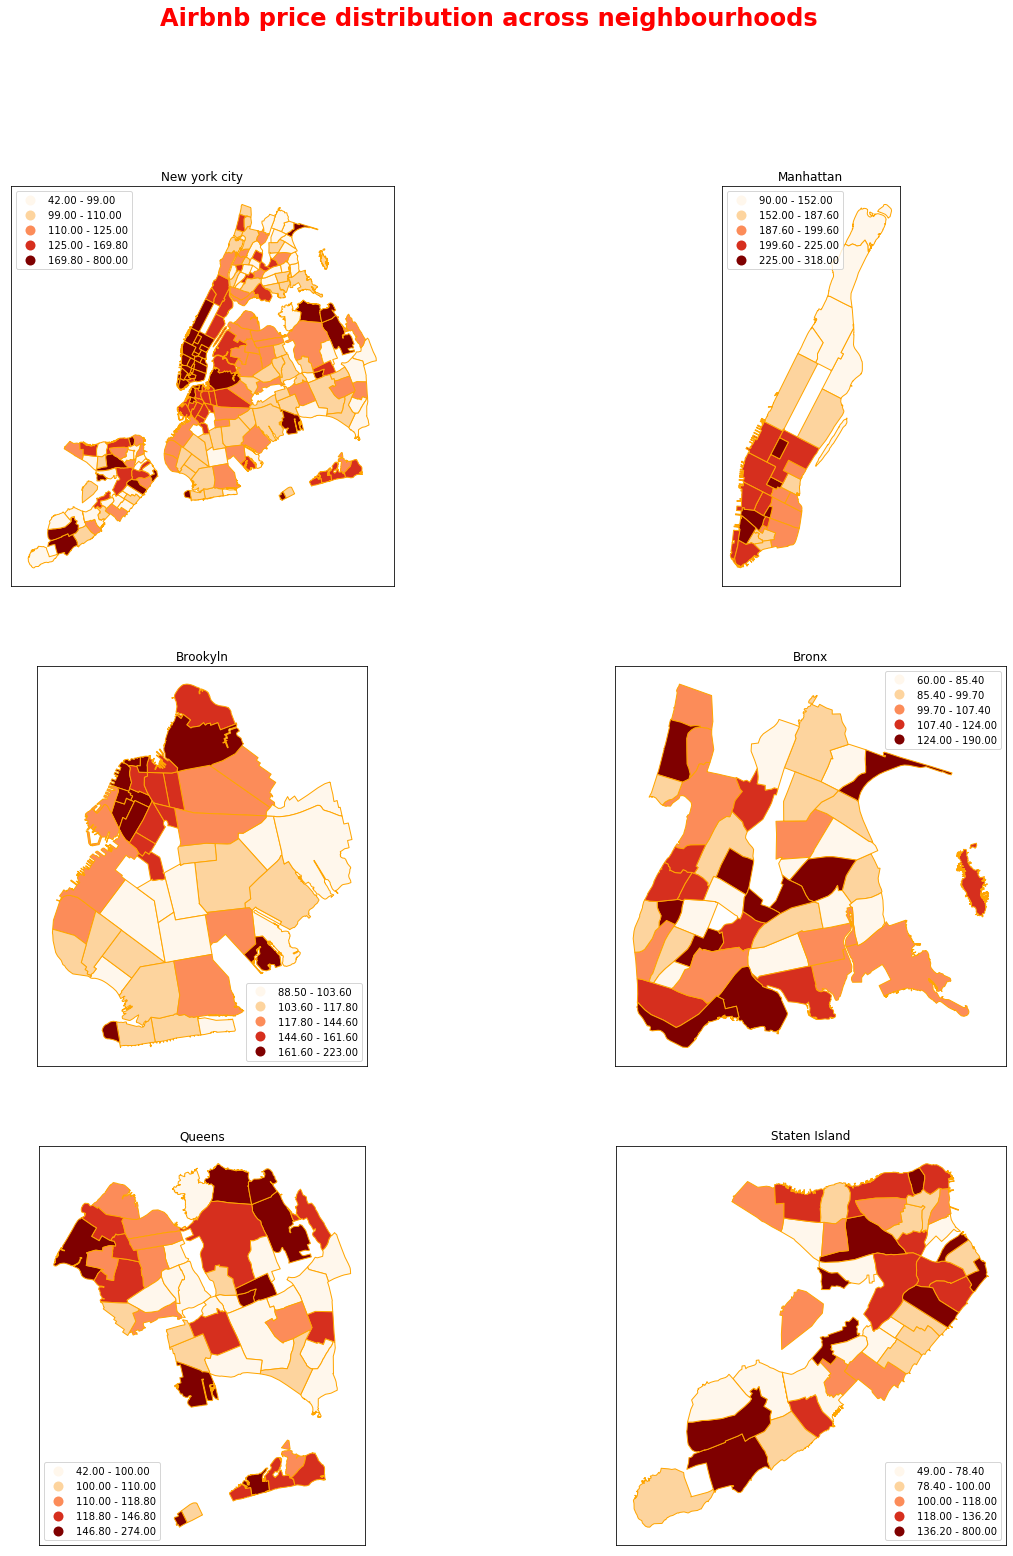

In [100]:
fig, axes = plt.subplots(3, 2)
fig.set_size_inches(20, 25)
axes[0,0] = plot_coloropeth_borough("all", axes[0,0], legend_pos["all"])
axes[0,0].set_title("New york city")
axes[0,1] = plot_coloropeth_borough("Manhattan", axes[0,1], legend_pos["Manhattan"])
axes[0,1].set_title("Manhattan")
axes[1,0] = plot_coloropeth_borough("Brooklyn", axes[1,0], legend_pos["Brooklyn"])
axes[1,0].set_title("Brookyln")
axes[1,1] = plot_coloropeth_borough("Bronx", axes[1,1], legend_pos["Bronx"])
axes[1,1].set_title("Bronx")
axes[2,0] = plot_coloropeth_borough("Queens", axes[2,0], legend_pos["Queens"])
axes[2,0].set_title("Queens")
axes[2,1] = plot_coloropeth_borough("Staten Island", axes[2,1], legend_pos["Staten Island"])
axes[2,1].set_title("Staten Island")

plt.suptitle("Airbnb price distribution across neighbourhoods", 
             fontsize=24, fontweight='bold', color='red')
plt.show()